# Segmentation + skills library building

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, accuracy_score
import datetime as dt

# from scipy import signal
from scipy.interpolate import make_splrep
import os
from pathlib import Path
from tqdm.auto import tqdm
from pprint import pprint
import ruptures as rpt
from movement_primitives.dmp import DMPWithFinalVelocity

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
    get_bagfiles_from_json,
)

In [3]:
from LfD_Library.MP_Library import gen_traj, MP_Library
from LfD_Library.sim_metrics import *

In [4]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

## Data files

In [5]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [6]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

In [7]:
bagfiles = get_bagfiles_from_json(ground_truth_segm_file=ground_truth_segm_file)
bagfiles

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [8]:
filenum = 1
bagfile = bagfiles[filenum]
bagfile

PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag')

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag`


  0%|          | 0/165202 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,0.261752,-0.304712,0.163383,2025-09-08 15:35:58.160103025-05:00,0.01
1,0.261756,-0.304691,0.163356,2025-09-08 15:35:58.162256640-05:00,0.01
2,0.261758,-0.304677,0.163334,2025-09-08 15:35:58.164200002-05:00,0.01
3,0.261751,-0.304663,0.163350,2025-09-08 15:35:58.166449013-05:00,0.01
4,0.261758,-0.304698,0.163376,2025-09-08 15:35:58.168195927-05:00,0.01
...,...,...,...,...,...
52060,0.407665,-0.285984,0.343602,2025-09-08 15:37:42.358578029-05:00,0.01
52061,0.407654,-0.285948,0.343613,2025-09-08 15:37:42.360238-05:00,0.01
52062,0.407671,-0.285977,0.343585,2025-09-08 15:37:42.361915215-05:00,0.01
52063,0.407681,-0.285969,0.343571,2025-09-08 15:37:42.364252706-05:00,0.01


In [10]:
# df = traj.diff().mean().timestamp.total_seconds()
# df

In [11]:
# downsampling = 10

In [12]:
# freq = 1 / (df * downsampling)
# freq

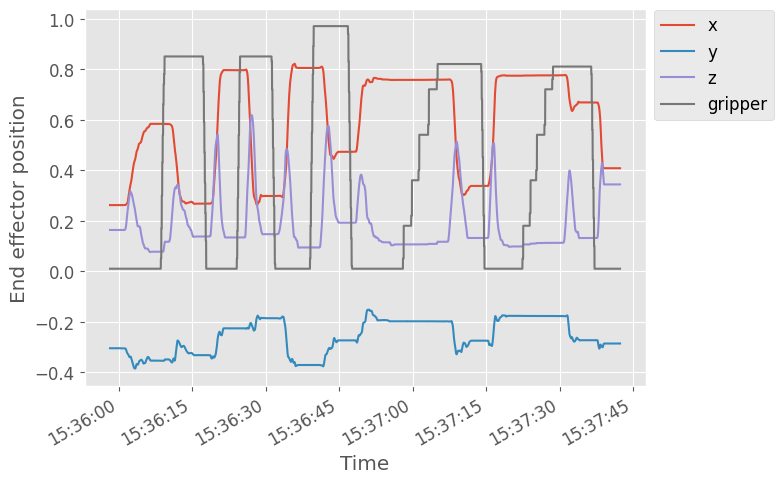

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [14]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
pprint(gt_segm_dict)

{'HigherLevel': {'cup': {'end': 1757363790, 'ini': 1757363779},
                 'fork': {'end': 1757363855, 'ini': 1757363835},
                 'napkin': {'end': 1757363805, 'ini': 1757363792},
                 'plate': {'end': 1757363776, 'ini': 1757363761},
                 'spoon': {'end': 1757363833, 'ini': 1757363808}},
 'LowerLevel': {'placing': [{'end': 1757363776, 'ini': 1757363771},
                            {'end': 1757363790, 'ini': 1757363786},
                            {'end': 1757363805, 'ini': 1757363801},
                            {'end': 1757363833, 'ini': 1757363827},
                            {'end': 1757363855, 'ini': 1757363851}],
                'reaching': [{'end': 1757363767, 'ini': 1757363761},
                             {'end': 1757363782, 'ini': 1757363779},
                             {'end': 1757363797, 'ini': 1757363792},
                             {'end': 1757363817, 'ini': 1757363808},
                             {'end': 1757363841, 'ini'

### Adding more features: objects moving

In [15]:
objects = np.zeros((traj.shape[0], len(gt_segm_dict["HigherLevel"].keys())))

In [16]:
for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
    sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
    xs = traj.timestamp[
        (
            traj.timestamp
            > pd.Timestamp(
                dt.datetime.fromtimestamp(sect_dict_current["ini"])
                - dt.timedelta(hours=1),
                tz="EST",
            )
        )
        & (
            traj.timestamp
            < pd.Timestamp(
                dt.datetime.fromtimestamp(sect_dict_current["end"])
                - dt.timedelta(hours=1),
                tz="EST",
            )
        )
    ]
    objects[xs.index, sect_i] = np.ones_like(xs)
objects

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], shape=(52065, 5))

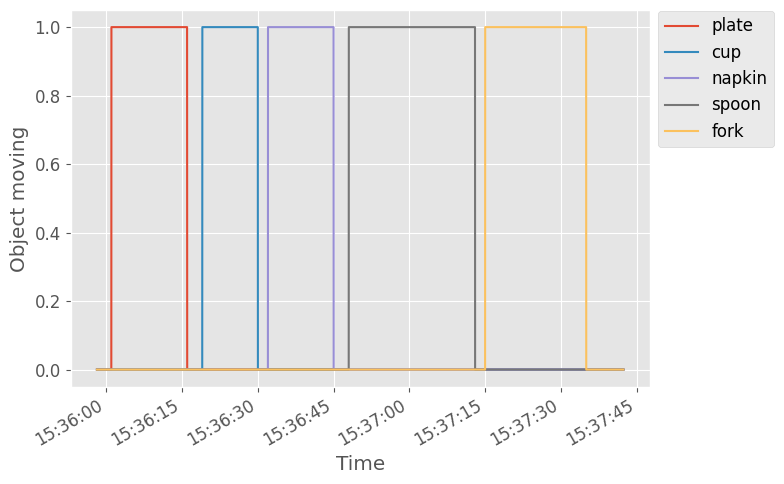

In [17]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    for idx in range(objects.shape[1]):
        ax.plot(
            traj.timestamp,
            objects[:, idx],
            label=list(gt_segm_dict["HigherLevel"].keys())[idx],
        )
    ax.set_xlabel("Time")
    ax.set_ylabel("Object moving")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [18]:
for idx in range(objects.shape[1]):
    traj[list(gt_segm_dict["HigherLevel"].keys())[idx]] = objects[:, idx]
traj

,x,y,z,timestamp,gripper,plate,cup,napkin,spoon,fork
0,0.261752,-0.304712,0.163383,2025-09-08 15:35:58.160103025-05:00,0.01,0.0,0.0,0.0,0.0,0.0
1,0.261756,-0.304691,0.163356,2025-09-08 15:35:58.162256640-05:00,0.01,0.0,0.0,0.0,0.0,0.0
2,0.261758,-0.304677,0.163334,2025-09-08 15:35:58.164200002-05:00,0.01,0.0,0.0,0.0,0.0,0.0
3,0.261751,-0.304663,0.163350,2025-09-08 15:35:58.166449013-05:00,0.01,0.0,0.0,0.0,0.0,0.0
4,0.261758,-0.304698,0.163376,2025-09-08 15:35:58.168195927-05:00,0.01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
52060,0.407665,-0.285984,0.343602,2025-09-08 15:37:42.358578029-05:00,0.01,0.0,0.0,0.0,0.0,0.0
52061,0.407654,-0.285948,0.343613,2025-09-08 15:37:42.360238-05:00,0.01,0.0,0.0,0.0,0.0,0.0
52062,0.407671,-0.285977,0.343585,2025-09-08 15:37:42.361915215-05:00,0.01,0.0,0.0,0.0,0.0,0.0
52063,0.407681,-0.285969,0.343571,2025-09-08 15:37:42.364252706-05:00,0.01,0.0,0.0,0.0,0.0,0.0


In [19]:
def add_more_features(ground_truth_segm_file, bagfile, traj):
    # Get the ground truth data for the BAG file
    gt_segm_dict = get_ground_truth_segmentation(
        ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
    )

    # Initialize the matrix
    objects = np.zeros((traj.shape[0], len(gt_segm_dict["HigherLevel"].keys())))

    # Set to ones for each object when it's moving
    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]
        objects[xs.index, sect_i] = np.ones_like(xs)

    # Merge with the original DataFrame
    for idx in range(objects.shape[1]):
        traj[list(gt_segm_dict["HigherLevel"].keys())[idx]] = objects[:, idx]
    return traj

### Higher level movements

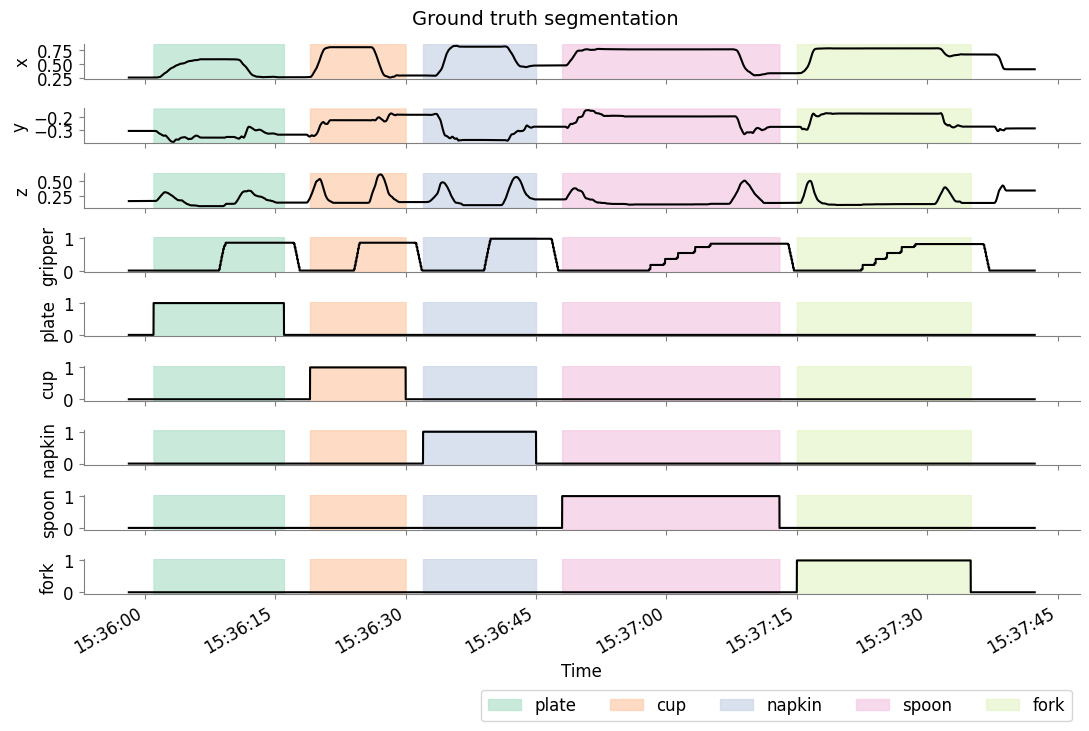

In [20]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_bottom,
            y2=y_top,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
axes[-1].legend(
    bbox_to_anchor=(1, -2.5),
    ncol=len(gt_segm_dict["HigherLevel"].keys()),
    fontsize=12,
)
plt.show()

### Lower level movements

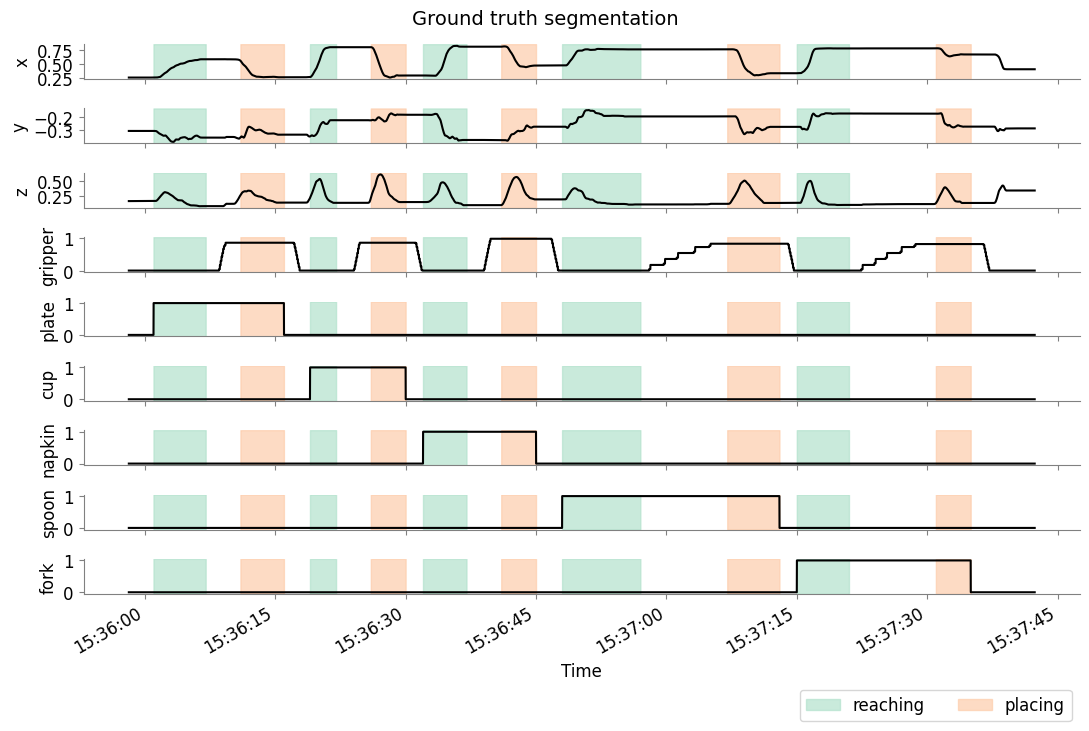

In [21]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
axes[-1].legend(
    bbox_to_anchor=(1, -2.5), ncol=len(gt_segm_dict["LowerLevel"].keys()), fontsize=12
)
plt.show()

## Segmentation

### Hyperparameters

In [22]:
# downsampling_factor = 200
resample_num = 2**8
# resample_num = 2**7
print(f"Resampling to {resample_num} data points")
# smoothing = 0.1

Resampling to 256 data points


In [23]:
what_segments = "HigherLevel"
# what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['plate', 'cup', 'napkin', 'spoon', 'fork'])

### Preprocessing

In [24]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper,plate,cup,napkin,spoon,fork
0,0.261752,-0.304712,0.163383,0.01,0.0,0.0,0.0,0.0,0.0
1,0.261756,-0.304691,0.163356,0.01,0.0,0.0,0.0,0.0,0.0
2,0.261758,-0.304677,0.163334,0.01,0.0,0.0,0.0,0.0,0.0
3,0.261751,-0.304663,0.163350,0.01,0.0,0.0,0.0,0.0,0.0
4,0.261758,-0.304698,0.163376,0.01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52060,0.407665,-0.285984,0.343602,0.01,0.0,0.0,0.0,0.0,0.0
52061,0.407654,-0.285948,0.343613,0.01,0.0,0.0,0.0,0.0,0.0
52062,0.407671,-0.285977,0.343585,0.01,0.0,0.0,0.0,0.0,0.0
52063,0.407681,-0.285969,0.343571,0.01,0.0,0.0,0.0,0.0,0.0


In [25]:
def smooth_traj(traj, nb_points=256):
    new_index = np.linspace(start=traj.index.start, stop=traj.index.stop, num=nb_points)
    for idx, col in enumerate(traj.columns):
        if idx == 0:
            traj_smooth = pd.DataFrame(
                {
                    col: make_splrep(x=traj.index, y=traj[col])(new_index),
                }
            )
        else:
            traj_smooth[col] = make_splrep(traj.index, traj[col])(new_index)
    return traj_smooth

In [26]:
# # X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
# X_down = signal.resample(x=X, num=resample_num, axis=0)
# X_down = smooth_traj(traj=X, nb_points=resample_num, smoothing=smoothing)
X_down = smooth_traj(traj=X, nb_points=resample_num)
X_down.shape

(256, 9)

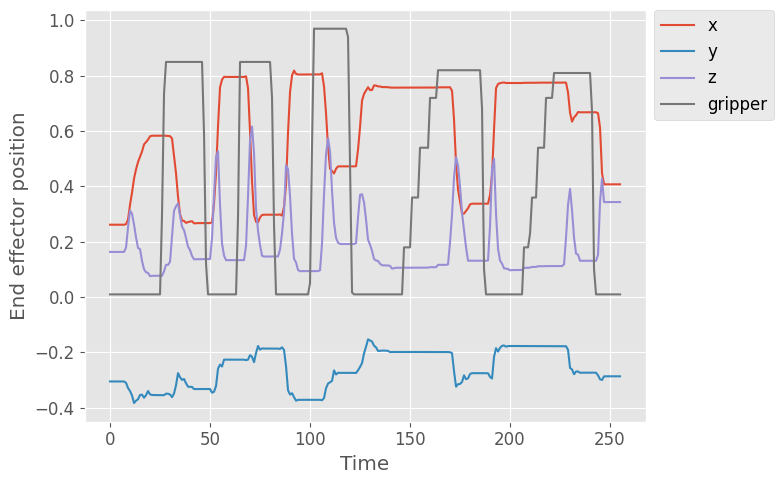

In [27]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(X_down.index, X_down.x, label="x")  # , color=cmap[0])
    ax.plot(X_down.index, X_down.y, label="y")  # , color=cmap[1])
    ax.plot(X_down.index, X_down.z, label="z")  # , color=cmap[2])
    ax.plot(X_down.index, X_down.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    # fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [28]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled

array([[2.66020759e-005, 3.38304082e-001, 1.61886521e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003],
       [1.86722012e-005, 3.38476845e-001, 1.61813555e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003],
       [2.25654553e-005, 3.38393500e-001, 1.61805043e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003],
       ...,
       [2.62028270e-001, 4.19755291e-001, 4.95155761e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003],
       [2.62033316e-001, 4.19803253e-001, 4.95175918e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003],
       [2.62027246e-001, 4.19221844e-001, 4.95453288e-001, ...,
        0.00000000e+000, 6.02882964e-114, 2.62015242e-003]],
      shape=(256, 9))

### Ruptures

In [29]:
if what_segments == "HigherLevel":
    # Higher level change points
    # penalty = 125
    penalty = 9
    true_chg_pts_iso = [segm["end"] for segm in gt_segm_dict[what_segments].values()]

else:
    # Lower level change points
    penalty = 90
    true_chg_pts_iso = []
    for skill in gt_segm_dict[what_segments].values():
        for segm in skill:
            true_chg_pts_iso.append(segm["end"])

true_chg_pts_iso

[1757363776, 1757363790, 1757363805, 1757363833, 1757363855]

In [30]:
true_chg_pts = np.empty_like(true_chg_pts_iso) * np.nan
true_chg_pts

array([nan, nan, nan, nan, nan])

In [31]:
for idx in range(len(true_chg_pts)):
    true_chg_pts[idx] = traj[
        traj.timestamp
        >= pd.Timestamp(
            dt.datetime.fromtimestamp(true_chg_pts_iso[idx]) - dt.timedelta(hours=1),
            tz="EST",
        )
    ].index[0]
true_chg_pts

array([ 8916., 15912., 23403., 37391., 48383.])

In [32]:
true_chg_pts_resampled = [
    round(item * resample_num / X.index.stop) for item in true_chg_pts
]
true_chg_pts_resampled

[44, 78, 115, 184, 238]

In [33]:
# detection
algo = rpt.Pelt(model="rbf").fit(X_down_scaled)
# algo = rpt.KernelCPD(kernel="rbf").fit(X_down_scaled)
# algo = rpt.KernelCPD(kernel="cosine").fit(X_scaled)
computed_chg_pts = algo.predict(pen=penalty)
print(computed_chg_pts)

[50, 80, 120, 185, 256]


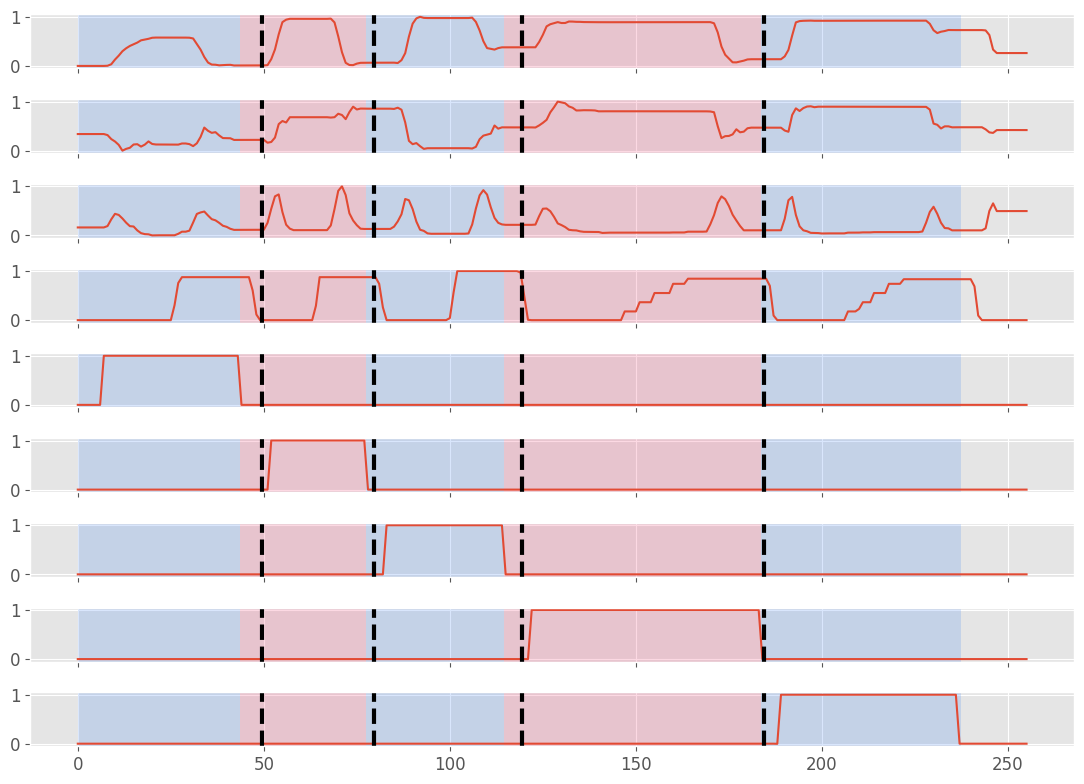

In [34]:
# display
with plt.style.context("ggplot_perso.mplstyle"):
    # rpt.display(minmaxscaler.inverse_transform(X_down_scaled), bkps, result)
    rpt.display(
        signal=X_down_scaled,
        true_chg_pts=true_chg_pts_resampled,
        computed_chg_pts=computed_chg_pts,
        figsize=(11, 8),
    )
    plt.show()

## LfD

In [35]:
execution_time = 1.0

In [36]:
chg_pts_all = np.concat([[0], computed_chg_pts])
chg_pts_all

array([  0,  50,  80, 120, 185, 256])

In [37]:
idx = 0
ts_segm = np.arange(chg_pts_all[idx], chg_pts_all[idx + 1])
ts_segm

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [38]:
pos_segm = X_down_scaled[chg_pts_all[idx] : chg_pts_all[idx + 1], 0:3]
pos_segm.shape

(50, 3)

In [39]:
n_dims = pos_segm.shape[1]

In [40]:
dt = 1 / len(ts_segm)
dt

0.02

In [41]:
dmp = DMPWithFinalVelocity(n_dims=n_dims, execution_time=execution_time, dt=dt)
dmp.imitate(ts_segm, pos_segm)

In [42]:
# goal_yd = 0.0
# dmp.configure(goal_yd=np.array([goal_yd, goal_yd]))
ts_segm_dmp, pos_segm_dmp = dmp.open_loop(run_t=execution_time)
ts_segm_dmp, pos_segm_dmp.shape

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 (51, 3))

In [43]:
dmp.reset()

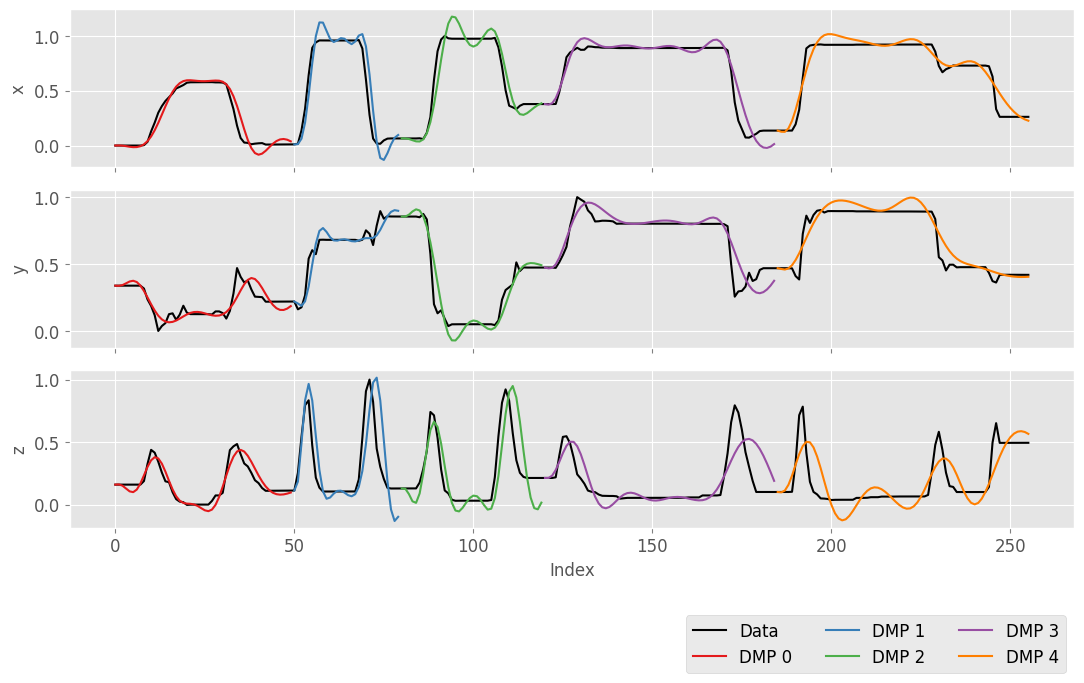

In [44]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, axes = plt.subplots(nrows=n_dims, ncols=1, sharex=True, figsize=(11, 7))
    cmap = mpl.colormaps.get("Set1").colors
    plt_labels = list(traj.drop(columns=["timestamp"]).keys())[0:3]
    ts = np.arange(stop=X_down_scaled.shape[0])
    for axi, axv in enumerate(axes):
        for item in (
            [axv.title, axv.xaxis.label, axv.yaxis.label]
            + axv.get_xticklabels()
            + axv.get_yticklabels()
        ):
            item.set_fontsize(12)
        axv.plot(X_down_scaled[:, axi], color="k", label="Data")
        axv.set_ylabel(plt_labels[axi])
        # axv.spines[["right", "top"]].set_visible(False)
        axv.tick_params(color="gray")
        # for spine in axv.spines.values():
        #     spine.set_edgecolor("gray")

    for seg_i, seg_v in enumerate(chg_pts_all[:-1]):
        # ts_segm = np.arange(start=chg_pts_all[seg_i], stop=chg_pts_all[seg_i + 1])
        ts_segm = np.arange(start=0, stop=chg_pts_all[seg_i + 1] - chg_pts_all[seg_i])
        pos_segm = X_down_scaled[chg_pts_all[seg_i] : chg_pts_all[seg_i + 1], 0:3]
        # pos_segm = X_down.to_numpy()[chg_pts_all[seg_i]:chg_pts_all[seg_i + 1], 0:3]
        dt = 1 / len(ts_segm)
        n_dims = pos_segm.shape[1]
        dmp = DMPWithFinalVelocity(n_dims=n_dims, execution_time=execution_time, dt=dt)
        # dmp = mp.dmp.DMP(n_dims=n_dims, execution_time=execution_time, dt=dt)
        dmp.imitate(ts_segm, pos_segm)
        ts_segm_dmp, pos_segm_dmp = dmp.open_loop(run_t=execution_time)
        for axi, axv in enumerate(axes):
            axv.plot(
                ts_segm + chg_pts_all[seg_i],
                pos_segm_dmp[: len(ts_segm), axi],
                color=cmap[seg_i],
                label=f"DMP {seg_i}",
            )

    axes[-1].set_xlabel("Index")
    axes[-1].legend(bbox_to_anchor=(1, -0.5), ncol=3, fontsize=12)
    fig.tight_layout()
    plt.show()

In [45]:
# """
# ==================
# Effect of DMP Gain
# ==================

# Demonstrates how modifying DMP gains (alpha_y, beta_y) affects
# the resulting trajectory reproduction.
# """
# print(__doc__)


# import matplotlib.pyplot as plt
# import numpy as np
# from movement_primitives.dmp import DMP


# dt = 0.01

# dmp1 = DMP(
#     n_dims=2,
#     execution_time=1.0,
#     dt=dt,
#     n_weights_per_dim=10,
#     int_dt=0.0001,
#     alpha_y=np.array([25.0, 25.0]),
#     beta_y=np.array([6.25, 6.25]),
# )

# dmp2 = DMP(
#     n_dims=2,
#     execution_time=1.0,
#     dt=dt,
#     n_weights_per_dim=10,
#     int_dt=0.0001,
#     alpha_y=np.array([25.0, 10.0]),  # note different alpha_y
#     beta_y=np.array([6.25, 3.0]),  # note different beta_y
# )

# T = np.linspace(0.0, 1.0, 101)
# Y = np.empty((101, 2))
# Y[:, 0] = np.cos(np.pi * T)
# Y[:, 1] = np.sin(np.pi * T)

# plt.plot(Y[:, 0], Y[:, 1], label="Demo")
# dmps = [dmp1, dmp2]
# for i, dmp in enumerate(dmps):

#     dmp.imitate(T, Y)
#     dmp.configure(start_y=Y[0], goal_y=Y[-1])
#     _, Y_ = dmp.open_loop()
#     plt.plot(Y_[:, 0], Y_[:, 1], label=f"Reproduction {i+1}")

# plt.grid()
# plt.gca().set_aspect("equal", "box")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("y")

# plt.show()

In [46]:
# """
# ======================
# Spatial Scaling of DMP
# ======================

# The standard DMP definition of Ijspeert et al. (2013) does not scale well,
# when the original demonstration has both the start and the goal state close
# together: small perturbation in the start and/or goal state often result in
# large accelerations. To fix this issue, our implementation of the DMP does
# not scale the forcing term by $(g - y_0)$. We also adopted the modification of

# P. Pastor, H. Hoffmann, T. Asfour, S. Schaal:
# Learning and Generalization of Motor Skills by Learning from Demonstration

# Note that this has to be activated explicitly by setting smooth scaling in the
# constructor of the DMP. This behavior is implemented for all types of DMPs.
# This example demonstrates the behavior of this DMP implementation in these
# cases.
# """
# import numpy as np
# import matplotlib.pyplot as plt
# from movement_primitives.dmp import DMP


# T = np.linspace(0, 1, 101)
# x = np.sin(T ** 2 * 1.99 * np.pi)
# y = np.cos(T ** 2 * 1.99 * np.pi)
# z = qx = qy = qz = np.zeros_like(x)
# qw = np.ones_like(x)
# Y = np.column_stack((x, y, z, qw, qx, qy, qz, x, y, z, qw, qx, qy, qz))
# start = Y[0]
# goal = Y[-1]
# new_start = np.array([0.5, 0.5, 0, 1, 0, 0, 0, 0.5, 0.5, 0, 1, 0, 0, 0])
# new_goal = np.array([-0.5, 0.5, 0, 1, 0, 0, 0, -0.5, 0.5, 0, 1, 0, 0, 0])
# Y_start_shifted = Y - start[np.newaxis] + new_start[np.newaxis]
# Y_goal_shifted = Y - goal[np.newaxis] + new_goal[np.newaxis]

# dmp = DMP(n_dims=len(start), execution_time=1.0, dt=0.01, n_weights_per_dim=20,
#           smooth_scaling=True)
# dmp.imitate(T, Y)
# dmp.configure(start_y=new_start, goal_y=new_goal)
# _, Y_dmp = dmp.open_loop()

# plt.plot(Y[:, 0], Y[:, 1], label=r"Demonstration, $g \approx y_0$", ls="--")
# plt.plot(Y_start_shifted[:, 0], Y_start_shifted[:, 1], label="Original shape with new start", ls="--")
# plt.plot(Y_goal_shifted[:, 0], Y_goal_shifted[:, 1], label="Original shape with new goal", ls="--")
# plt.plot(Y_dmp[:, 0], Y_dmp[:, 1], label="DMP with new goal", lw=5, alpha=0.5)
# plt.scatter(Y_dmp[:, 0], Y_dmp[:, 1], alpha=0.5)
# plt.scatter(goal[0], goal[1], c="r", label="Goal of demonstration: $g$")
# plt.scatter(start[0], start[1], c="g", label="Start of demonstration: $y_0$")
# plt.scatter(new_start[0], new_start[1], c="c", label="New start: $y_0'$")
# plt.scatter(new_goal[0], new_goal[1], c="y", label="New goal: $g'$")
# plt.xlabel("$y_1$")
# plt.ylabel("$y_2$")
# plt.legend(loc="best", ncol=2)
# plt.xlim((-1.8, 2.1))
# plt.ylim((-1.7, 2.2))
# plt.tight_layout()
# plt.show()

## Build skills library

In [47]:
### Resample segments to the same length
chg_pts_conv_ori = np.array(
    [int(round(item * len(traj) / resample_num)) for item in chg_pts_all]
)
chg_pts_conv_ori

array([    0, 10169, 16270, 24405, 37625, 52065])

In [48]:
similarity_threshold = 2.0

In [49]:
# demos = []
# for seg_i, seg_v in enumerate(chg_pts_all[:-1]):
#     # ts_segm = np.arange(start=0, stop=chg_pts_all[seg_i + 1] - chg_pts_all[seg_i])
#     pos_segm = X_down_scaled[chg_pts_all[seg_i] : chg_pts_all[seg_i + 1], 0:4]
#     # demos.append(np.concat((ts_segm[:, np.newaxis], pos_segm), axis=1))
#     print(pos_segm.shape)
#     demos.append(pos_segm)

In [50]:
def resample_array(array, nb_points=256):
    ori_index = np.arange(array.shape[0])
    new_index = np.linspace(start=0, stop=array.shape[0], num=nb_points)
    arr_resampled = np.ones((nb_points, array.shape[1])) * np.nan
    for colidx, _ in enumerate(range(array.shape[1])):
        arr_resampled[:, colidx] = make_splrep(ori_index, array[:, colidx])(new_index)
    return arr_resampled

In [51]:
demos = []
for seg_i, seg_v in enumerate(chg_pts_conv_ori[:-1]):
    pos_segm = X.iloc[
        chg_pts_conv_ori[seg_i] : chg_pts_conv_ori[seg_i + 1], 0:4
    ].to_numpy()
    pos_segm_resampled = resample_array(pos_segm, nb_points=resample_num)
    print(
        f"Original shape: {pos_segm.shape} - resampled shape: {pos_segm_resampled.shape}"
    )
    demos.append(pos_segm_resampled)

Original shape: (10169, 4) - resampled shape: (256, 4)
Original shape: (6101, 4) - resampled shape: (256, 4)
Original shape: (8135, 4) - resampled shape: (256, 4)
Original shape: (13220, 4) - resampled shape: (256, 4)
Original shape: (14440, 4) - resampled shape: (256, 4)


In [52]:
lib_path = Path("lib.h5")
if lib_path.exists():
    lib_path.unlink()
library = MP_Library(metric=COS_metric, threshold=similarity_threshold, debug=True)
for demo_i in demos:
    library.add_primitive(demo_i)
library.display()
with plt.style.context("ggplot_perso.mplstyle"):
    library.plot()
    library.plot_separate()
library.save_h5(lib_path)

Class not matched, new class: 'demo0'
Class: 'demo0' - Similarity: 110.088
Class not matched, new class: 'demo1'
Class: 'demo0' - Similarity: 103.432
Class: 'demo1' - Similarity: 114.823
Class not matched, new class: 'demo2'
Class: 'demo0' - Similarity: 137.722
Class: 'demo1' - Similarity: 114.633
Class: 'demo2' - Similarity: 137.077
Class not matched, new class: 'demo3'
Class: 'demo0' - Similarity: 124.349
Class: 'demo1' - Similarity: 120.544
Class: 'demo2' - Similarity: 142.084
Class: 'demo3' - Similarity: 122.100
Class not matched, new class: 'demo4'
------------------
--- MP_Library ---
------------------
+ demo0: 1
+ demo1: 1
+ demo2: 1
+ demo3: 1
+ demo4: 1
------------------
Plotting not yet implemented for more than 2 dimensions!
Plotting not yet implemented for more than 2 dimensions!


In [53]:
# similarity_threshold = 2.0

In [54]:
# x1, y1 = gen_traj(0.5)
# demo1 = np.hstack((np.reshape(x1, (len(x1), 1)), np.reshape(y1, (len(y1), 1))))
# x1, y1 = gen_traj(0.6)
# demo2 = np.hstack((np.reshape(x1, (len(x1), 1)), np.reshape(y1, (len(y1), 1))))
# x1, y1 = gen_traj(1.0)
# demo3 = np.hstack((np.reshape(x1, (len(x1), 1)), np.reshape(y1, (len(y1), 1))))
# x1, y1 = gen_traj(1.5)
# demo4 = np.hstack((np.reshape(x1, (len(x1), 1)), np.reshape(y1, (len(y1), 1))))
# x1, y1 = gen_traj(1.6)
# demo5 = np.hstack((np.reshape(x1, (len(x1), 1)), np.reshape(y1, (len(y1), 1))))

In [55]:
# lib_path = Path("test.h5")
# if lib_path.exists():
#     lib_path.unlink()
# library = MP_Library(metric=COS_metric, threshold=similarity_threshold, debug=True)
# library.add_primitive(demo1)
# library.add_primitive(demo2)
# # library.add_primitive(demo3)
# library.add_primitive(demo4)
# # library.add_primitive(demo5)
# library.display()
# with plt.style.context("ggplot_perso.mplstyle"):
#     library.plot()
#     library.plot_separate()
# library.save_h5(lib_path)

In [56]:
# new_library = MP_Library(metric=COS_metric, threshold=similarity_threshold, debug=True)
# new_library.load_h5(lib_path)
# # new_library.add_primitive(demo1)
# # new_library.add_primitive(demo2)
# new_library.add_primitive(demo3)
# new_library.add_primitive(demo4)
# new_library.add_primitive(demo5)
# new_library.display()
# with plt.style.context("ggplot_perso.mplstyle"):
#     new_library.plot()
#     new_library.plot_separate()